# Fascicle evaluation

One of the challenges for users of tractography algorithms is how to validate the results of tractography, and to compare results of different tractography algorithms. We demonstrate here how to compare the tracks from the [deterministic tractography](det_track.ipynb) and [probablistic tractography](prob_track.ipynb) examples. These are two algorithms that provide slightly different models of the white matter. One set of curves is slighlty less "wiggly", and traverses the white matter in a slightly more direct curve. 

Here, we demonstrate how these results can be compared to each other, and evaluated with respect to the data, using the LiFE (linear fascicle evaluation method) introduced in Pestilli et al. (2014). This method creates a linear model in which each one of the tracks contributes to the signal. The optimal weights for each track are found, and an 'optimized' version of the tracks can be derived, by culling out the tracks that have a weight equal to 0. We demonstrate this process below.

We start by importing a few functions that we will use in this example:

In [1]:
import os.path as op

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

import dipy.core.gradients as grad

from IPython.display import display, Image

We read in the data that was used for tracking:

In [3]:
dwi_ni = nib.load(op.join('data', 'SUB1_b2000_1.nii.gz'))
data = dwi_ni.get_fdata()
affine = dwi_ni.affine
gtab = grad.gradient_table(op.join('data','SUB1_b2000_1.bvals'), op.join('data', 'SUB1_b2000_1.bvecs'))

In this case, we have two sets of candidate tracks, one from each algorithm:

In [12]:
trk = nib.streamlines.load('prob-track.trk')

/Users/arokem/miniconda3/envs/vwm/lib/python3.9/site-packages/nibabel/streamlines/trk.py:609: HeaderWarning: Field 'vox_to_ras' in the TRK's header was not recorded. Will continue assuming it's the identity.
  warnings.warn(("Field 'vox_to_ras' in the TRK's header was"


In [15]:
candidate_prob = nib.streamlines.load('prob-track.trk').streamlines
candidate_det = nib.streamlines.load('det-track.trk').streamlines

/Users/arokem/miniconda3/envs/vwm/lib/python3.9/site-packages/nibabel/streamlines/trk.py:609: HeaderWarning: Field 'vox_to_ras' in the TRK's header was not recorded. Will continue assuming it's the identity.
  warnings.warn(("Field 'vox_to_ras' in the TRK's header was"


We set up the LiFE model:

In [16]:
import dipy.tracking.life as life
fiber_model = life.FiberModel(gtab)

We fit the model separately for each one of the tracks:

In [17]:
fit_prob = fiber_model.fit(data, candidate_prob, affine=np.eye(4))
fit_det = fiber_model.fit(data, candidate_det, affine=np.eye(4))

The two sets of tracks have different weight distributions. Many of the tracks from the deterministic algorithm do not contribute to the signal (weight=0).

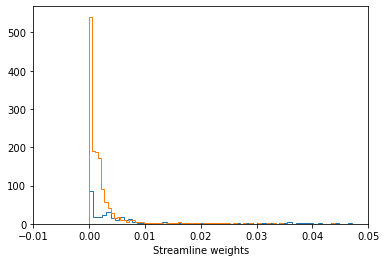

In [18]:
fig, ax = plt.subplots(1)
ax.hist(fit_prob.beta, bins=100, histtype='step')
ax.hist(fit_det.beta, bins=100, histtype='step')
ax.set_xlim([-0.01, 0.05])
ax.set_xlabel('Streamline weights')
ax.set_label('# streamlines')

We create an optimized set of tracks by culling all the tracks that have a weight of 0:

In [27]:
optimized_prob = list(np.array(candidate_prob)[np.where(fit_prob.beta>0)[0]])

<ipython-input-27-f3ef6f650108>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optimized_prob = list(np.array(candidate_prob)[np.where(fit_prob.beta>0)[0]])


What proportion of the streamlines survived this culling?

In [28]:
len(optimized_prob)/float(len(candidate_prob))

0.7547169811320755

We can visualize the remaining tacks as follows

In [29]:
from dipy.viz import window, actor, colormap, has_fury
from dipy.tracking.utils import transform_tracking_output
from numpy.linalg import inv
t1 = nib.load(op.join('data', 'SUB1_t1_resamp.nii.gz'))
t1_data = t1.get_fdata()
t1_aff = t1.affine

In [30]:
color = colormap.line_colors(optimized_prob)

In [31]:

# streamlines_actor = actor.streamtube(list(transform_tracking_output(streamlines, inv(t1_aff))),
#                                      color)


streamlines_actor = actor.streamtube(optimized_prob, color)

/Users/arokem/miniconda3/envs/vwm/lib/python3.9/site-packages/fury/utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [33]:
vol_actor = actor.slicer(t1_data)
vol_actor.display_extent(0, t1_data.shape[0]-1, 0, t1_data.shape[1]-1, 25, 25)

In [35]:
scene = window.Scene()
scene.add(streamlines_actor)
scene.add(vol_actor)
window.record(scene, out_path='life-prob-track.png', size=(600,600))

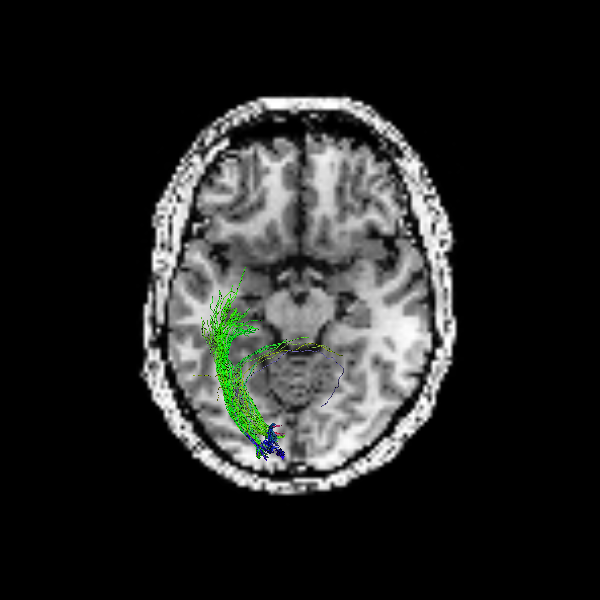

In [36]:
display(Image(filename='life-prob-track.png'))

To see how the LiFE algorithm can be used to calculate the error related to optimized tracks, relative to a non-optimized solution, please refer to the Dipy documentation example [here](http://nipy.org/dipy/examples_built/linear_fascicle_evaluation.html). 